In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [2]:
with open("dataAll.pickle", "rb") as infile:
    data = pickle.load(infile)

In [3]:
IDs = ['5153', '5300', '5250', '5342', '5214', '5242', '5341', '5245', '5269', '5426', '5154', '5207', '5284', '5297', '5158', '5376', '5259', '5350', '5412', '5264', '5299', '5367', '5282', '5210', '5263', '5358', '5251', '5110', '5186', '5303', '5349', '5352', '5374', '5457', '5322', '5147', '5325', '5351', '5375', '5213', '5323', '5354', '5156', '5310', '5347', '5180', '5379', '5415', '5472', '5149']
print(IDs)

['5153', '5300', '5250', '5342', '5214', '5242', '5341', '5245', '5269', '5426', '5154', '5207', '5284', '5297', '5158', '5376', '5259', '5350', '5412', '5264', '5299', '5367', '5282', '5210', '5263', '5358', '5251', '5110', '5186', '5303', '5349', '5352', '5374', '5457', '5322', '5147', '5325', '5351', '5375', '5213', '5323', '5354', '5156', '5310', '5347', '5180', '5379', '5415', '5472', '5149']


In [4]:
%matplotlib inline
import json
import requests
import time
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pickle
import copy
from collections import defaultdict, Counter
import os
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
import pandas as pd
import copy
from sklearn.preprocessing import MinMaxScaler
from IPython.display import clear_output
url = "http://localhost:51016/api/DTWNew"

In [5]:
ope = "3.26"
dataAll = defaultdict(list)

batchFiles = [filename for filename in os.listdir("recipe421/") if filename.endswith(".pickle")]
try:
    with open("dataAll.pickle", "rb") as infile:
        dataAll = pickle.load(infile)
except:
    for filename in batchFiles:
        batchId = filename[:4]
        with open("recipe421/{}".format(filename), "rb") as infile:
            batchData = pickle.load(infile)
        for tagName, pv in batchData['Units']['3']['Operations'][ope]['PVs'].items():
            if len(pv) > 1:
                pv['name'] = pv['TagName']
                _ = pv.pop('TagName')
                dataAll[batchId].append(pv)
        #print(len(dataAll[batchId]), end = " ")
    with open("dataAll.pickle", "wb") as handle:
        pickle.dump(dataAll, handle, protocol=pickle.HIGHEST_PROTOCOL)

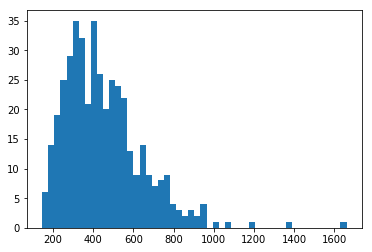

In [6]:
opeLen = list()
pvDataset = list()
for _id, pvs in dataAll.items():
    opeLen.append((len(pvs[0]['values']), _id))
    pvList = list()
    for pv in pvs:
        pvList.append(pv['name'])
    pvDataset.append(pvList)
plt.hist([l for l, _id in opeLen], bins=50)
plt.show()

In [7]:
print("Min: {}\nMax: {}\nMedian: {}\nMean: {:.02f}".format(min([l for l, _id in opeLen]), max([l for l, _id in opeLen]), np.median([l for l, _id in opeLen]), np.mean([l for l, _id in opeLen])))

Min: 146
Max: 1661
Median: 415.0
Mean: 452.32


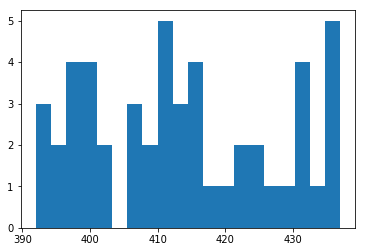

In [8]:
medLen = np.median([l for l, _id in opeLen])

# Select the N=50 closest to the median bacthes
# center around the median
centered = [(abs(l-medLen), _id) for l, _id in opeLen]
selected = sorted(centered)[:50]
plt.hist([l for l, _id in opeLen if _id in [ID for d, ID in selected]], bins = 20)
plt.show()

In [9]:
IDs = list(dataAll.keys())
for _id in IDs:
    L = len(dataAll[_id])
    if L != 99:
        dataAll.pop(_id)
print(len(dataAll))

294


In [10]:
data = dict()
for d, _id in selected:
    data[_id] = copy.copy(dataAll[_id])
print(len(data))
print(data.keys())
IDs = list(data.keys())

50
dict_keys(['5153', '5300', '5250', '5342', '5214', '5242', '5341', '5245', '5269', '5426', '5154', '5207', '5284', '5297', '5158', '5376', '5259', '5350', '5412', '5264', '5299', '5367', '5282', '5210', '5263', '5358', '5251', '5110', '5186', '5303', '5349', '5352', '5374', '5457', '5322', '5147', '5325', '5351', '5375', '5213', '5323', '5354', '5156', '5310', '5347', '5180', '5379', '5415', '5472', '5149'])


In [11]:
data['reference'] = selected[0][1]
data['reference']
#_ = data.pop('5091') # problems, yet to understand

'5153'

In [12]:
pvNames = [(pv['name'], j) for pv, j in zip(data[data['reference']], range(len(data[data['reference']])))]    

In [13]:
PVsDict = {j: pv['name'] for j, pv in zip(range(len(data['5153'])), data['5153'])}
constPVs = []
for j in PVsDict.keys():
    zeroVar = True
    for _id, pvs in data.items():
        if _id != "reference":
            var = np.var(pvs[j]['values'])
            if var > 1e-6:
                zeroVar = False
    if zeroVar:
        constPVs.append(j)
print(constPVs, len(constPVs))


[0, 6, 7, 8, 9, 10, 16, 17, 20, 22, 23, 33, 34, 35, 36, 37, 38, 39, 40, 43, 48, 49, 50, 51, 55, 56, 57, 58, 59, 62, 63, 64, 65, 68, 75, 76, 78, 79, 80, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 97, 98] 52


In [14]:
for j in constPVs:
    _ = PVsDict.pop(j)
PVsDict

{1: 'ba_FQ2Qyx',
 2: 'ba_FQADMQfb0z',
 3: 'ba_FQYXdr6Q0',
 4: 'ba_FQNOJG',
 5: 'ba_FQnZKYLSO02xLf',
 11: 'ba_FCobtZJfb5TG',
 12: 'ba_FC7fl4f1HT5',
 13: 'ba_FCywcBXpqpo',
 14: 'ba_FC7NvzX',
 15: 'ba_FIhgSwHD',
 18: 'ba_FC3BnZ',
 19: 'ba_FCFGHiEU9Kn',
 21: 'ba_FmYOrhonkk',
 24: 'ba_PLAu1m2',
 25: 'ba_PCPUSq5ah',
 26: 'ba_SinhbKA',
 27: 'ba_TIJSj',
 28: 'ba_TrWfpiPrs',
 29: 'ba_TC06nRC',
 30: 'ba_TCyNE8Mdv',
 31: 'ba_TZNCmUn29mO',
 32: 'ba_Fl7pvjqC',
 41: 'ba_ErguU',
 42: 'ba_FpxlMOAyc5',
 44: 'ba_PCGd0srEZp',
 45: 'ba_PCLAMr1nuoSiAr',
 46: 'ba_PCSTgdwK3V',
 47: 'ba_PCG6Z9',
 52: 'ba_TCzWpXo',
 53: 'ba_TCfg3Yxn',
 54: 'ba_TCkwAse0bopy8zp6',
 60: 'ba_FCGUglDXyPKrnk38',
 61: 'ba_FCDvhG4',
 66: 'ba_TDZyHMh1UZ',
 67: 'ba_TDZV2zDOrmiYP',
 69: 'ba_PfrAayv8',
 70: 'ba_FQT7dzM2wq51Z3JW',
 71: 'ba_FQh8rKXE0',
 72: 'ba_FQ1kbQwOUVlR',
 73: 'ba_FQraEXT',
 74: 'ba_FQVzNY',
 77: 'ba_FQC6tzztBV4DeXemfp',
 81: 'ba_TZv9w2dOu',
 82: 'ba_TZIm086h',
 83: 'ba_TZHx41ABpBbhN',
 84: 'ba_TZWZNzFFdHb',
 96: 'ba_PC

In [15]:
def filterPVs(data, pvSet):
    out = defaultdict(list)
    for key, item in data.items():
        if key != 'reference':
            for idx in pvSet:
                out[key].append(item[idx])

    return out

In [16]:
def pairwiseDist(refBatch, queryBatch):
    dist = 0
    scale = MinMaxScaler()
    for name, pv in refBatch.items():
        x = scale.fit_transform(X=np.array(pv['values']).reshape(-1,1))
        y = scale.fit_transform(X=np.array(queryBatch[name]['values']).reshape(-1,1))
        dist += np.linalg.norm(x-y, ord=2)
    return np.sqrt(dist)

In [17]:
def groupProcess(dataRaw, pvs, refId):
    # filter pvs
    output = list()
    data = filterPVs(dataRaw, pvs)
    data['reference'] = refId
    
    batchIds = [key for key in data.keys() if key != 'reference' and key!= refId]
    
    # align bacthes
    ok = False
    while not ok:
        try:
            result = json.loads(requests.post(url,json=json.dumps(data)).text)
            ok = True
        except:
            time.sleep(1)
    
    #compute distance and save results
    refBatch = result[refId]
    res = {"refId" : refId,
          "queryId": 0,
          "DTW_dist": 0,
          "PVs": pvs}
    for _id in batchIds:
        try:
            queryBatch = result[_id]
            res['queryId'] = _id
            res['DTW_dist'] = pairwiseDist(refBatch, queryBatch)
        except:
            res['queryId'] = _id
            res['DTW_dist'] = np.nan
        output.append(copy.deepcopy(res))
    
    return output

In [18]:
def analysis(refId, data, pvs, groupSize):
    # group ids
    
    data['reference'] = refId
    keys = [key for key in data.keys() if key != 'reference' and key != refId]

    groupIds = [keys[i*groupSize:(i+1)*groupSize] for i in range(0,len(keys)//groupSize+1)]
    L = len(groupIds)
    for group in groupIds:
        print(L, end = " ")
        L -= 1
        dataGroup = dict()
        dataGroup[refId] = copy.copy(data[refId])
        dataGroup['reference'] = refId
        for _id in group:
            dataGroup[_id] = data[_id]
            
        for pvIds in pvs:
            yield groupProcess(dataGroup, pvIds, refId)

In [19]:
def oneMorePV(selectedPVs, folder, data):
    ids = [key for key in data.keys() if key != 'reference']
    L = len(ids)
    
    try : os.mkdir("operation3_26/{}".format(folder))
    except: pass
    
    for refId in ids:
        print(L)
        if "Operation3_26_{}.csv".format(refId) not in os.listdir("operation3_26/{}/".format(folder)):
            df = pd.DataFrame()
            #start = time.time()

            for res in analysis(refId, data, [selectedPVs + [i] for i in PVsDict.keys() if i not in selectedPVs], groupSize=25):
                df = df.append(pd.DataFrame(res), ignore_index=True)
            #print("Elapsed {:.0f} seconds".format(time.time() - start), end = "")
            print("")

            df.to_csv("operation3_26/{}/Operation3_26_{}.csv".format(folder, refId), header = True, index = False)
        L -= 1
        if L%10 == 0: clear_output()
    clear_output()
    print("Done")

In [20]:
selectedPVs = []

In [21]:
folder = "1variate"
_ = oneMorePV(selectedPVs, folder, data)

firstChoice = list()
for file in os.listdir("operation3_26/{}/".format(folder)):
    if file.endswith(".csv"):
        df = pd.read_csv("operation3_26/{}/{}".format(folder, file), header = 0)
        df = df.groupby(by="PVs").aggregate({"DTW_dist" : "sum"})
        df.sort_values(by="DTW_dist", ascending= True, inplace= True)
        firstChoice.append(df.index[0])
print(Counter(firstChoice))

Done
Counter({'[3]': 25, '[46]': 15, '[45]': 6, '[60]': 3, '[25]': 1})


In [22]:
selectedPVs.append(3)
selectedPVs

[3]

Code to remove non constant but still non informative variables

In [23]:
toRemove = 
for file in os.listdir("operation3_26/{}/".format(folder)):
    if file.endswith(".csv"):
        df = pd.read_csv("operation3_26/{}/{}".format(folder, file), header = 0)
        df = df[df.PVs != '[{}]'.format(toRemove)]
        df.to_csv("operation3_26/{}/{}".format(folder, file), index = False)
_ = PVsDict.pop(toRemove)

SyntaxError: invalid syntax (<ipython-input-23-170ee3221e0f>, line 1)

In [24]:
oldKeys = [1, 2, 3, 4, 5, 11, 12, 13, 14, 15, 18, 19, 21, 24, 25, 26, 27, 28, 29, 30, 31, 32, 41, 42, 44, 45, 46, 47, 52, 53, 54, 60, 61, 66, 67, 69, 70, 71, 72, 73, 74, 77, 81, 82, 83, 84, 96]
newKeys = [1, 3, 4, 5, 13, 15, 18, 21, 24, 25, 26, 27, 28, 29, 30, 31, 32, 41, 45, 46, 47, 54, 60, 61, 66, 67, 69, 74, 81, 82, 83, 84]
for key in oldKeys:
    if key not in newKeys:
        try: _ = PVsDict.pop(key)
        except: pass
print(oldKeys)
print(newKeys)
print(list(PVsDict.keys()))

[1, 2, 3, 4, 5, 11, 12, 13, 14, 15, 18, 19, 21, 24, 25, 26, 27, 28, 29, 30, 31, 32, 41, 42, 44, 45, 46, 47, 52, 53, 54, 60, 61, 66, 67, 69, 70, 71, 72, 73, 74, 77, 81, 82, 83, 84, 96]
[1, 3, 4, 5, 13, 15, 18, 21, 24, 25, 26, 27, 28, 29, 30, 31, 32, 41, 45, 46, 47, 54, 60, 61, 66, 67, 69, 74, 81, 82, 83, 84]
[1, 3, 4, 5, 13, 15, 18, 21, 24, 25, 26, 27, 28, 29, 30, 31, 32, 41, 45, 46, 47, 54, 60, 61, 66, 67, 69, 74, 81, 82, 83, 84]


In [25]:
folder = "2variate"
_ = oneMorePV(selectedPVs, folder, data)

firstChoice = list()
for file in os.listdir("operation3_26/{}/".format(folder)):
    if file.endswith(".csv"):
        df = pd.read_csv("operation3_26/{}/{}".format(folder, file), header = 0)
        df = df.groupby(by="PVs").aggregate({"DTW_dist" : "sum"})
        df.sort_values(by="DTW_dist", ascending= True, inplace= True)
        firstChoice.append(df.index[0])
print(Counter(firstChoice))

Done
Counter({'[3, 46]': 44, '[3, 25]': 4, '[3, 45]': 2})


In [26]:
selectedPVs.append(46)
selectedPVs

[3, 46]

In [27]:
folder = "3variate"
_ = oneMorePV(selectedPVs, folder, data)

firstChoice = list()
for file in os.listdir("operation3_26/{}/".format(folder)):
    if file.endswith(".csv"):
        df = pd.read_csv("operation3_26/{}/{}".format(folder, file), header = 0)
        df = df.groupby(by="PVs").aggregate({"DTW_dist" : "sum"})
        df.sort_values(by="DTW_dist", ascending= True, inplace= True)
        firstChoice.append(df.index[0])
print(Counter(firstChoice))

Done
Counter({'[3, 46, 25]': 27, '[3, 46, 45]': 16, '[3, 46, 30]': 3, '[3, 46, 15]': 2, '[3, 46, 66]': 1, '[3, 46, 67]': 1})


In [28]:
selectedPVs.append(25)
selectedPVs

[3, 46, 25]

In [29]:
folder = "4variate"
_ = oneMorePV(selectedPVs, folder, data)

firstChoice = list()
for file in os.listdir("operation3_26/{}/".format(folder)):
    if file.endswith(".csv"):
        df = pd.read_csv("operation3_26/{}/{}".format(folder, file), header = 0)
        df = df.groupby(by="PVs").aggregate({"DTW_dist" : "sum"})
        df.sort_values(by="DTW_dist", ascending= True, inplace= True)
        firstChoice.append(df.index[0])
print(Counter(firstChoice))

Done
Counter({'[3, 46, 25, 45]': 29, '[3, 46, 25, 66]': 8, '[3, 46, 25, 30]': 5, '[3, 46, 25, 67]': 5, '[3, 46, 25, 15]': 1, '[3, 46, 25, 18]': 1, '[3, 46, 25, 84]': 1})


In [30]:
selectedPVs.append(45)
selectedPVs

[3, 46, 25, 45]

In [32]:
folder = "5variate"
_ = oneMorePV(selectedPVs, folder, data)

firstChoice = list()
for file in os.listdir("operation3_26/{}/".format(folder)):
    if file.endswith(".csv"):
        df = pd.read_csv("operation3_26/{}/{}".format(folder, file), header = 0)
        df = df.groupby(by="PVs").aggregate({"DTW_dist" : "sum"})
        df.sort_values(by="DTW_dist", ascending= True, inplace= True)
        firstChoice.append(df.index[0])
print(Counter(firstChoice))

Done
Counter({'[3, 46, 25, 45, 30]': 27, '[3, 46, 25, 45, 66]': 13, '[3, 46, 25, 45, 67]': 5, '[3, 46, 25, 45, 84]': 2, '[3, 46, 25, 45, 15]': 1, '[3, 46, 25, 45, 18]': 1, '[3, 46, 25, 45, 83]': 1})


In [34]:
selectedPVs.append(30)
selectedPVs

[3, 46, 25, 45, 30]

In [37]:
folder = "6variate"
_ = oneMorePV(selectedPVs, folder, data)

firstChoice = list()
for file in os.listdir("operation3_26/{}/".format(folder)):
    if file.endswith(".csv"):
        df = pd.read_csv("operation3_26/{}/{}".format(folder, file), header = 0)
        df = df.groupby(by="PVs").aggregate({"DTW_dist" : "sum"})
        df.sort_values(by="DTW_dist", ascending= True, inplace= True)
        firstChoice.append(df.index[0])
print(Counter(firstChoice))

Done
Counter({'[3, 46, 25, 45, 30, 84]': 23, '[3, 46, 25, 45, 30, 83]': 10, '[3, 46, 25, 45, 30, 66]': 10, '[3, 46, 25, 45, 30, 67]': 5, '[3, 46, 25, 45, 30, 15]': 1, '[3, 46, 25, 45, 30, 18]': 1})


In [38]:
selectedPVs.append(84)
selectedPVs

[3, 46, 25, 45, 30, 84]

In [41]:
folder = "7variate"
_ = oneMorePV(selectedPVs, folder, data)

firstChoice = list()
for file in os.listdir("operation3_26/{}/".format(folder)):
    if file.endswith(".csv"):
        df = pd.read_csv("operation3_26/{}/{}".format(folder, file), header = 0)
        df = df.groupby(by="PVs").aggregate({"DTW_dist" : "sum"})
        df.sort_values(by="DTW_dist", ascending= True, inplace= True)
        firstChoice.append(df.index[0])
print(Counter(firstChoice))

Done
Counter({'[3, 46, 25, 45, 30, 84, 83]': 35, '[3, 46, 25, 45, 30, 84, 66]': 10, '[3, 46, 25, 45, 30, 84, 67]': 3, '[3, 46, 25, 45, 30, 84, 15]': 1, '[3, 46, 25, 45, 30, 84, 18]': 1})


In [54]:
selectedPVs.append(83)
selectedPVs

[3, 46, 25, 45, 30, 84, 83]

In [57]:
folder = "8variate"
_ = oneMorePV(selectedPVs, folder, data)

firstChoice = list()
for file in os.listdir("operation3_26/{}/".format(folder)):
    if file.endswith(".csv"):
        df = pd.read_csv("operation3_26/{}/{}".format(folder, file), header = 0)
        df = df.groupby(by="PVs").aggregate({"DTW_dist" : "sum"})
        df.sort_values(by="DTW_dist", ascending= True, inplace= True)
        firstChoice.append(df.index[0])
print(Counter(firstChoice))

Done
Counter({'[3, 46, 25, 45, 30, 84, 83, 66]': 25, '[3, 46, 25, 45, 30, 84, 83, 67]': 23, '[3, 46, 25, 45, 30, 84, 83, 15]': 1, '[3, 46, 25, 45, 30, 84, 83, 18]': 1})


In [69]:
selectedPVs.append(66)
selectedPVs

[3, 46, 25, 45, 30, 84, 83, 66]

In [81]:
folder = "9variate"
_ = oneMorePV(selectedPVs, folder, data)

firstChoice = list()
for file in os.listdir("operation3_26/{}/".format(folder)):
    if file.endswith(".csv"):
        df = pd.read_csv("operation3_26/{}/{}".format(folder, file), header = 0)
        df = df.groupby(by="PVs").aggregate({"DTW_dist" : "sum"})
        df.sort_values(by="DTW_dist", ascending= True, inplace= True)
        firstChoice.append(df.index[0])
print(Counter(firstChoice))

30
2 1 
29
2 1 
28
2 1 
27
2 1 
26
2 1 
25
2 1 
24
2 1 

KeyError: '5251'

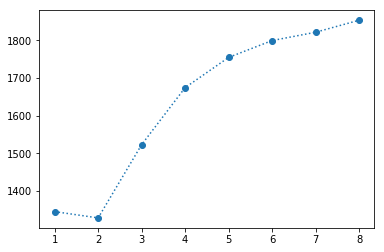

In [80]:
varDist = []
for i in range(1,9):
    folder = "{}variate".format(i)
    firstChoice = list()
    for file in os.listdir("operation3_26/{}/".format(folder)):
        if file.endswith(".csv"):
            df = pd.read_csv("operation3_26/{}/{}".format(folder, file), header = 0)
            df = df.groupby(by="PVs").aggregate({"DTW_dist" : "sum"})
            df.sort_values(by="DTW_dist", ascending= True, inplace= True)
            firstChoice.append(df.index[0])
   
    count = Counter(firstChoice)
    mostCommon = count.most_common()[0][0]

    dist = 0
    for file in os.listdir("operation3_26/{}/".format(folder)):
        if file.endswith(".csv"):
            df = pd.read_csv("operation3_26/{}/{}".format(folder, file), header = 0)
            df = df.groupby(by="PVs").aggregate({"DTW_dist" : "sum"})
            dist += df.loc[mostCommon, "DTW_dist"]
    varDist.append((i, dist/np.sqrt(i))) # dimensionality problem

plt.plot([x for x,y in varDist], [y for x, y in varDist], "o:")
plt.show()

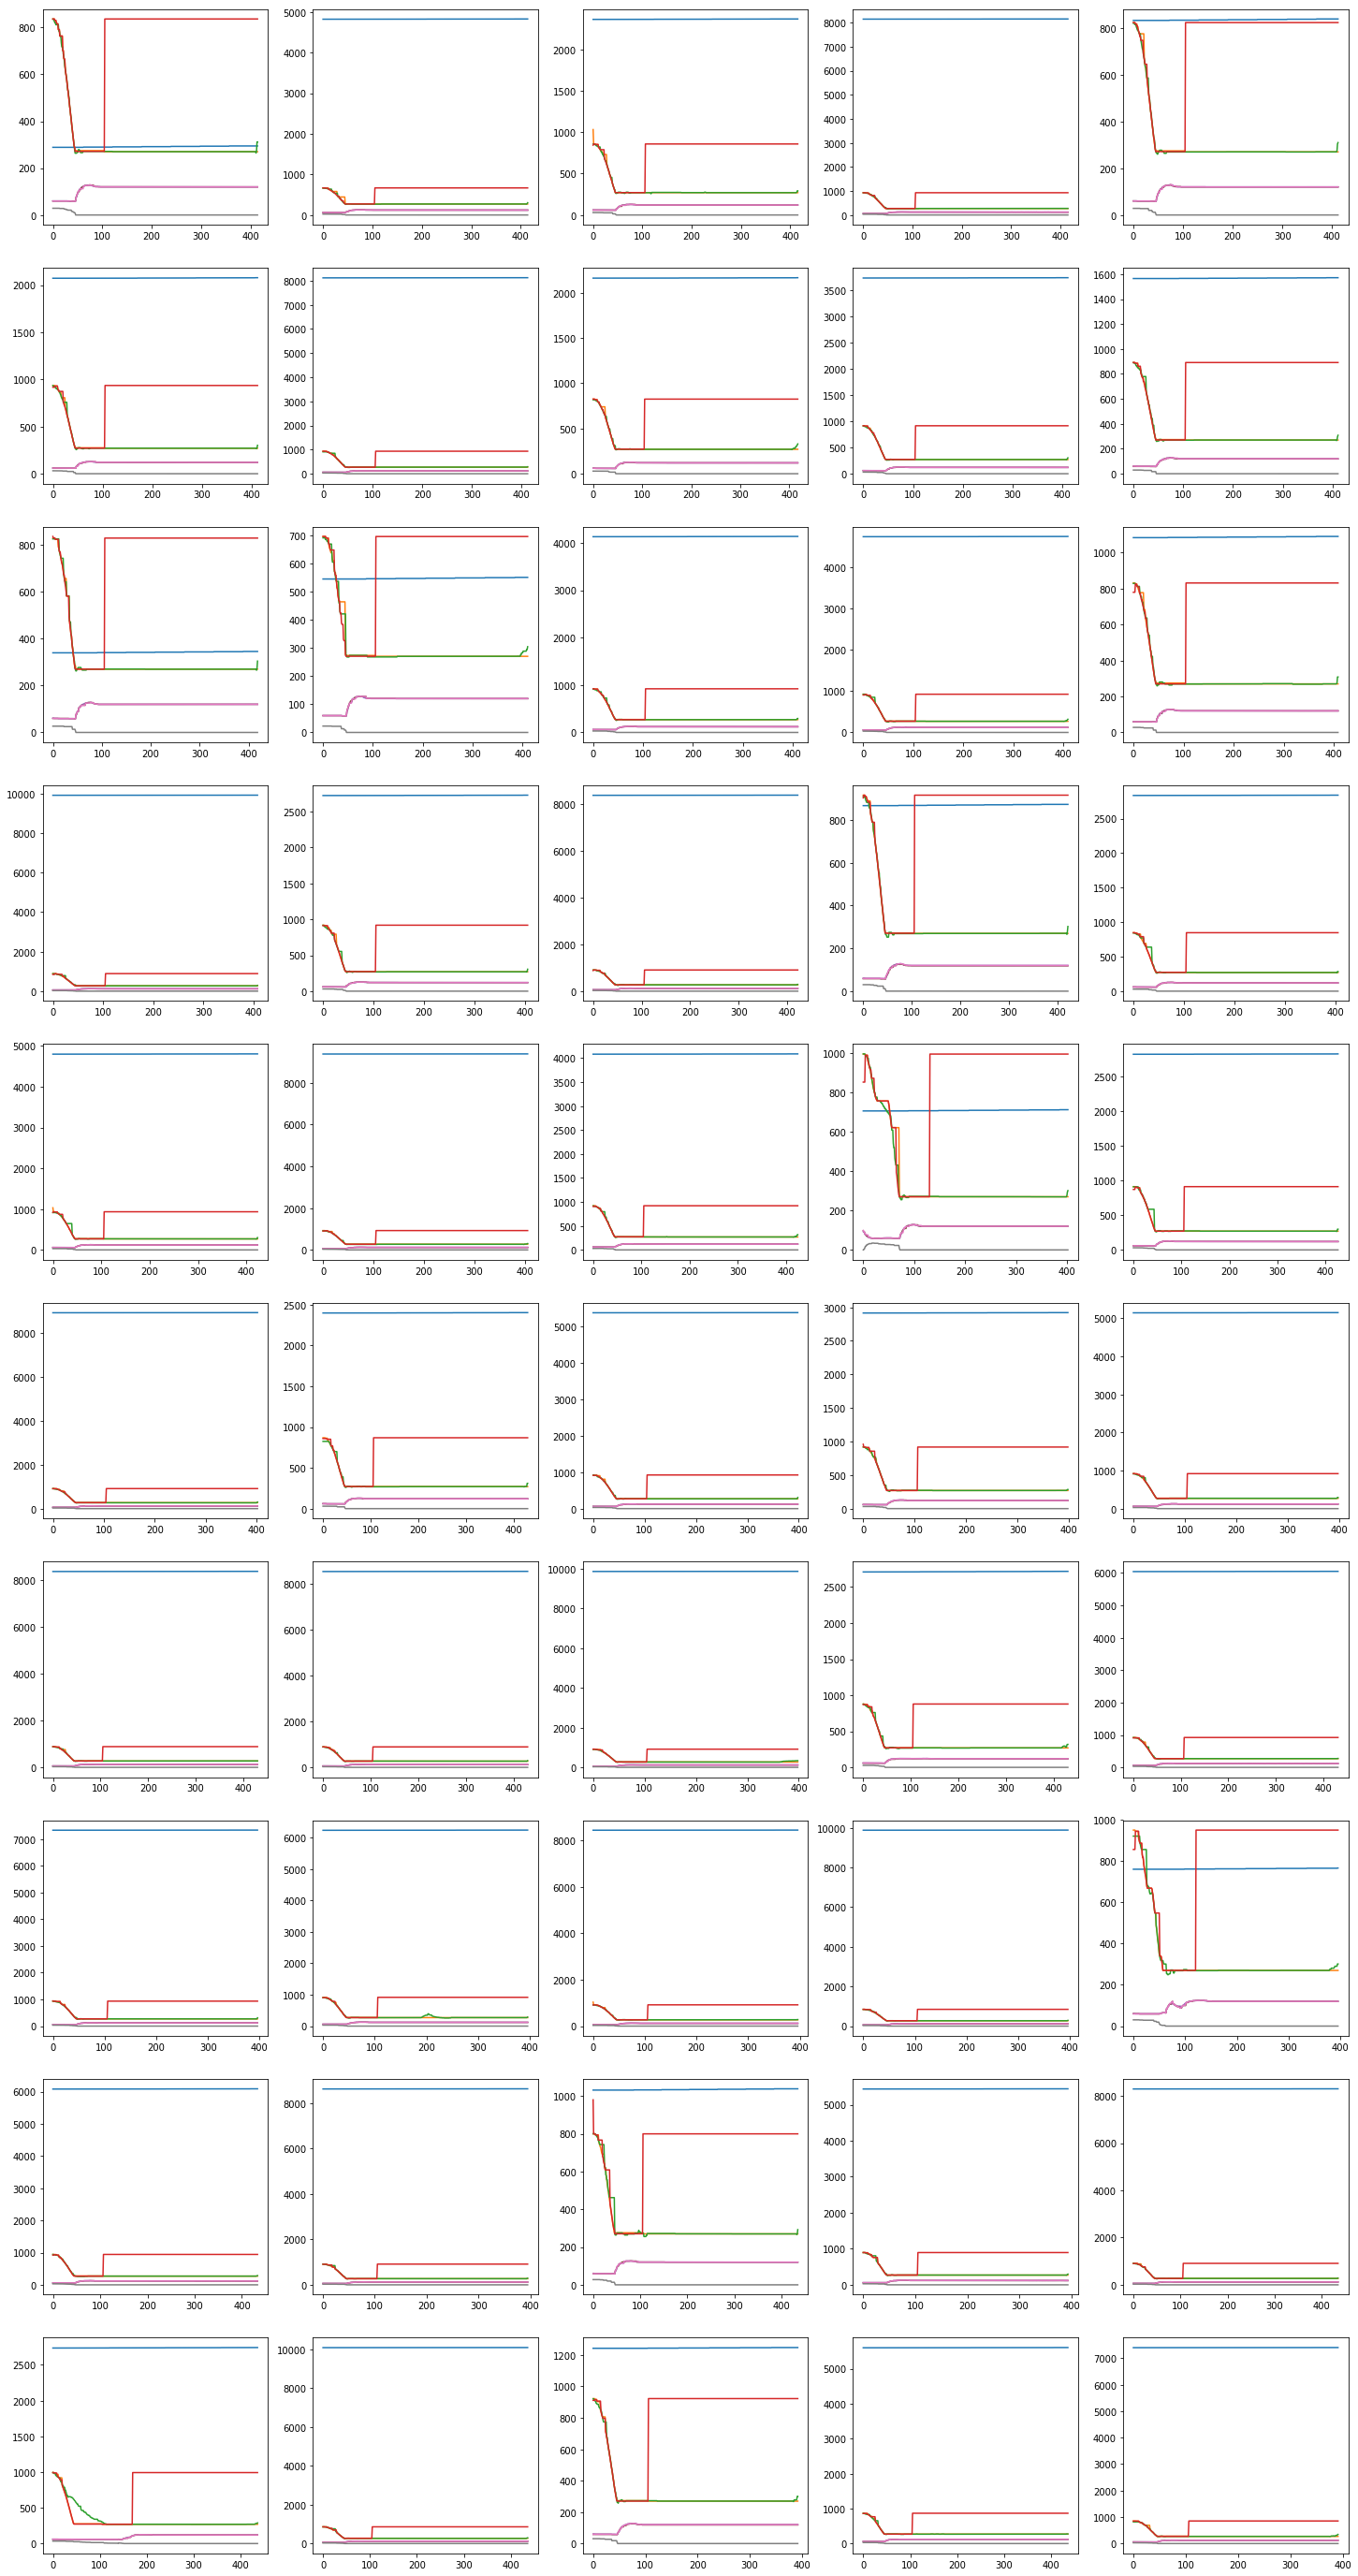

In [72]:
fig, ax = plt.subplots(ncols=5, nrows=10)
fig.set_figwidth(25)
fig.set_figheight(50)
pvIdx = [3, 46, 25, 45, 30, 84, 83, 66]
for i, _id in zip(range(50), IDs):
    x = np.unravel_index([i], (10, 5))[0][0]
    y = np.unravel_index([i], (10, 5))[1][0]
    for idx in pvIdx:
        ax[x, y].plot(data[_id][idx]['values'])
plt.show()